# Linear Regression with closed form solution + K-fold cross validation

Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as r
import scipy.io as sio
%matplotlib inline

Define the function to compute cost function

In [21]:
def computeError(x, y, theta):
    """
    Calculates the cost function J and returns it
    to the caller.
    
    Parameters
    ----------
    x : Nxd matrix
        N is number of samples and d is number of params
    y : Nx1 matrix
        The matrix storing the actual outputs
    theta: 1xd matrix
        The matrix storing regression parameters
    
    Returns
    -------
    Nx1 matrix
        Matrix storing prediction error for each input
        data point
    """
    return (x * theta - y)

In [6]:
def computeCost(error):
    """
    Calculates the overall cost and returns it
    to the caller.
    
    Parameters
    ----------
    error : Nx1 matrix
        Matrix storing prediction error for each
        input data point where N is the number of
        input data points
    
    Returns
    -------
    float
        Overall cost for the current step calculated
        as (sum of squared error) / (2 * N)
    """
    inner = np.power(error, 2)
    return np.sum(inner) / (2 * len(error))

In [7]:
def computeTheta(X, Y, l2_penality):
    """
    Calculates theta using the closed form solution.
    This method uses the following formula to
    calculate the value of regression parameters:
    theta = ((X.T*X)^(-1))*(X.T*Y)
    where:
    X is a matrix storing the input data points,
    Y is the observed outputs,
    X.T represents the transpose of a matrix X and
    theta is a matrix storing the regression params
    
    Parameters
    ----------
    X : Nxd matrix
        N is the number of input samples and d is 
        the number of features
    Y : Nx1 matrix
        The matrix storing the actual outputs
    l2_penality : float
        The L2 penality to be applied
    
    Returns
    -------
    dx1 matrix
        The calculated regression parameters
    """
    I = np.eye(X.shape[1])
    I = I*l2_penality
    
    inversePart = np.power(X.T*X + I, -1)
    rest = X.T*Y
    return inversePart*rest

In [8]:
def generate_folds(X, k, randomize = False):
    """
    Generates k (training, validation) pairs from
    the given data
    
    Parameters
    ----------
    X : Nxd matrix
        where N is the total number of input data
        points and d is the number of features
    k : Integer
        Number of folds to be generated
    randomize : boolean
        True iff data must be shuffled before
        being split into (training, validation)
        pairs
    
    Yields
    ------
    k (training, validation) pairs
    """
    
    # Shuffle the data if necessary    
    if randomize:
        X = list(X)
        r.shuffle(X)
    
    for i in range(k):
        training = [x for j, x in enumerate(X, start = 1) if j % k != i]
        validation = [x for j, x in enumerate(X, start = 1) if j % k == i]
        yield training, validation

In [16]:
def do_k_fold_CV(data, l2_penality_values, K):
    
    # For each value of L2 penality, compute
    # the average MSE after fitting a model
    # for each fold
    l2_penality_mse = np.zeros(len(l2_penality_values))
    
    # Define variables to track the min MSE
    # and best L2 penality
    min_mse = None
    best_l2_penality = None
    
    # Create as many folds as needed for cross
    # validation and run linear regression on
    # each training-validation pair
    for training, validation in generate_folds(data.values, K, True):
        
        # Convert the splits into dataframe
        t_df = pd.DataFrame(training)
        v_df = pd.DataFrame(validation)
        
        # Split the datasets into X and Y
        t_X = t_df.iloc[:, 0:2]
        t_Y = t_df.iloc[:, 2:]
        v_X = v_df.iloc[:, 0:2]
        v_Y = v_df.iloc[:, 2:]
        
        # Convert X and Y into matrices
        t_X = np.matrix(t_X.values)
        t_Y = np.matrix(t_Y.values)
        v_X = np.matrix(v_X.values)
        v_Y = np.matrix(v_Y.values)
        
        for i, l2_penality in enumerate(l2_penality_values):
            # Initialize theta
            t_theta = computeTheta(t_X, t_Y, l2_penality)
            
            # Predict validation set outputs
            v_Y_prediction = v_X * t_theta
            #print("v_Y_prediction: ", v_Y_prediction.shape)
            v_l1_error = v_Y_prediction - v_Y
            #print("v_l1_error: ", v_l1_error.shape)
            v_l2_error = v_l1_error.T * v_l1_error
            #print("v_l2_error: ", v_l2_error.shape)
            l2_penality_mse[i] += v_l2_error.sum()
    
    l2_penality_mse = l2_penality_mse / K
    
    # Find the min mse and corresponding l2 penality
    min_mse = None
    best_l2_penality = None
    
    for i, val in enumerate(l2_penality_mse):
        if min_mse is None or val < min_mse:
            min_mse = val
            best_l2_penality = l2_penality_values[i]            
    
    return l2_penality_mse, best_l2_penality

In [40]:
def add_polynomial_cols(data, degree, result_col_name):
    """
    Generate polynomial columns for all
    columns in the data based on the
    specified degree.
    
    Parameters
    ----------
    data : Pandas DataFrame
        The data to be manipulated
    degree : Integer
        The polynomial degree
    result_col_name : String
        The name of the column that stores
        the results
    
    Returns
    -------
    Pandas DataFrame
        storing the updated data
    """
    # Fetch the list of column names
    cols = list(data.columns.values)
    
    # Create polynomial columns for all
    # except the result column
    for col in cols:
        if (col != result_col_name):
            for i in range(degree + 1):
                if (i != 1):
                    new_col_name = col + str(i)
                    data[new_col_name] = data[col].apply(lambda x: pow(x, i))
        
    return data

def pre_process(data, result_col_name, degree):
    # Add polynomial columns
    data = add_polynomial_cols(data, degree, result_col_name)
    
    # Split data and result columns into
    # X and Y
    data_cols = list(data.columns.values)
    data_cols.remove(result_col_name)
    
    X = data[data_cols]
    X = np.matrix(X.values)
    
    Y = data[[result_col_name]]
    Y = np.matrix(Y.values)
    
    return data, X, Y

def load_train_data(path):
    train_data = sio.loadmat(path)
    train_data = pd.DataFrame(np.hstack((train_data['X_trn'], train_data['Y_trn'])))
    train_data.columns = ['X_trn', 'Y_trn']
    return train_data

def plot_training_data_fit(train_data, degree, theta):
    x = np.linspace(train_data.X_trn.min(), train_data.X_trn.max(), 100)

    f = 0
    for i in range(degree + 1):
        f += (theta[i, 0] * pow(x, i))

    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(x, f, 'r', label='Prediction')
    ax.scatter(train_data.X_trn, train_data.Y_trn, label='Traning Data')
    ax.legend(loc=2)
    ax.set_xlabel('X_trn')
    ax.set_ylabel('Y_trn')
    ax.set_title('Predicted X_trn vs. Y_trn')

def generate_model(path, result_col_name, degree, folds=None):    
    train_data = load_train_data(path)
    train_data, X, Y = pre_process(train_data, result_col_name, degree)
    
    if folds is None:
        folds = X.shape[0]
    
    # K-fold CV
    l2_penality_values = np.logspace(-4, 10, num=10)
    l2_penality_mse, best_l2_penality = do_k_fold_CV(train_data, l2_penality_values, folds)
    print("L2 Penality MSEs: ", l2_penality_mse)
    print("Best L2 penality value: ", best_l2_penality)
    
    plot_cv_error(l2_penality_values, l2_penality_mse)
    
    theta = computeTheta(X, Y, best_l2_penality)
    print("Theta: ", theta)
    
    error = computeError(X, Y, theta)
    print("Test Regression error: ", error.sum())
    
    cost = computeCost(error)
    print("Test error: ", cost.sum())
    
    plot_training_data_fit(train_data, degree, theta)
    
    return theta

def load_test_data(path):
    test_data = sio.loadmat(path)
    test_data = pd.DataFrame(np.hstack((test_data['X_tst'], test_data['Y_tst'])))
    test_data.columns = ['X_tst', 'Y_tst']
    return test_data

def plot_test_data_fit(test_data, degree, theta):
    x = np.linspace(test_data.X_tst.min(), test_data.X_tst.max(), 100)

    f = 0
    for i in range(degree + 1):
        f += (theta[i, 0] * pow(x, i))

    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(x, f, 'r', label='Prediction')
    ax.scatter(test_data.X_tst, test_data.Y_tst, label='Test Data')
    ax.legend(loc=2)
    ax.set_xlabel('X_tst')
    ax.set_ylabel('Y_tst')
    ax.set_title('Predicted X_tst vs. Y_tst')

def plot_cv_error(l2_penality_values, l2_penality_mse):
    plt.plot(l2_penality_values, l2_penality_mse, 'k-')
    plt.xlabel('$\ell_2$ penalty')
    plt.ylabel('K-fold cross validation error')
    plt.xscale('log')
    plt.yscale('log')

def predict(path, result_col_name, degree, theta):
    test_data = load_test_data(path)
    test_data, X, Y = pre_process(test_data, result_col_name, degree)
    
    error = computeError(X, Y, theta)
    print("Training regression error: ", error.sum())
    
    cost = computeCost(error)
    print("Training error: ", cost.sum())
    
    plot_test_data_fit(test_data, degree, theta)

L2 Penality MSEs:  [  4.76531501e+08   4.76531023e+08   4.76513856e+08   4.75898568e+08
   4.55761245e+08   2.96239890e+08   1.92044488e+08   1.00496906e+08
   9.43928110e+07   9.42171899e+07]
Best L2 penality value:  10000000000.0
Theta:  [[  4.21294950e+01]
 [ -6.31751852e+02]
 [ -1.10530821e+01]
 [  8.63361943e-01]
 [ -1.82948118e-01]
 [  2.05157361e-02]]
Test Regression error:  -115880.230009
Test error:  953773.141426
Training regression error:  -6538.22892223
Training error:  346043.658272


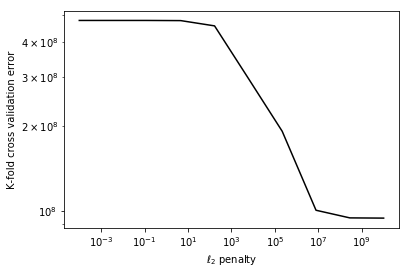

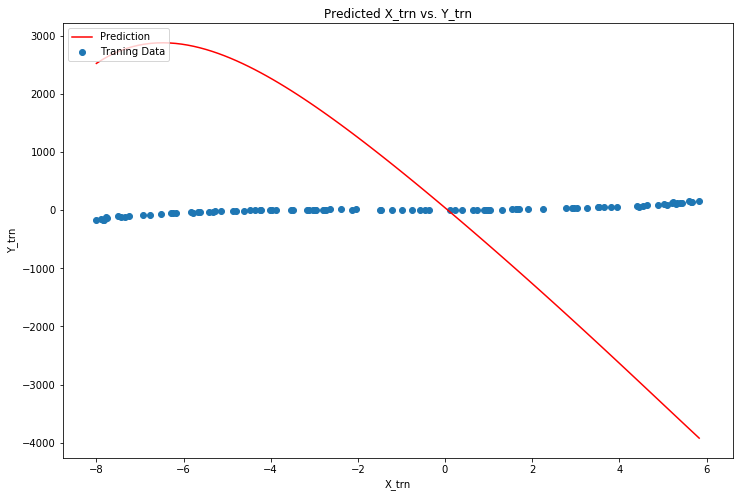

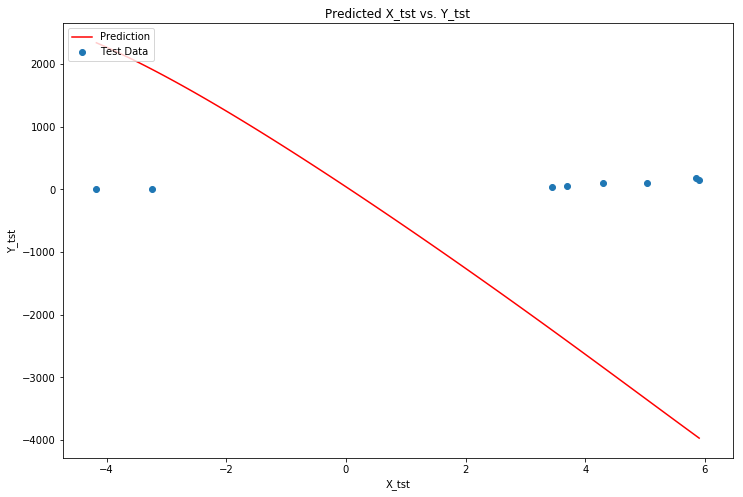

In [47]:
path = "dataset2.mat"
result_col_name = "Y_trn"
degree = 5
folds = None

theta = generate_model(path, result_col_name, degree, folds)

result_col_name = "Y_tst"

predict(path, result_col_name, degree, theta)